In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras import layers, models 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
#for dirname, _, filenames in os.walk('../input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# preproccesing

In [3]:
def wb(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel

In [4]:
labels = []
data=[]
Uninfected=os.listdir("./input/data/NORMAL")
for a in Uninfected:
	# extract the class label from the filename
	

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread("./input/data/NORMAL/"+a)
	imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
	gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
	img_clahe1 = clahe.apply(gray_image)
	img = cv2.cvtColor(img_clahe1, cv2.COLOR_GRAY2RGB)
	image = cv2.resize(img, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(0)

Infected=os.listdir("./input/data/PNEUMONIA")
for b in Infected:
	# extract the class label from the filename
	

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread("./input/data/PNEUMONIA/"+b)
	imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
	gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
	img_clahe1 = clahe.apply(gray_image)
	img = cv2.cvtColor(img_clahe1, cv2.COLOR_GRAY2RGB)
	image = cv2.resize(img, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(1)

In [5]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [6]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, labels,stratify=labels,
	test_size=0.20,  random_state=42)

In [7]:
trainAug  = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping

## model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam


def conv_layer(conv_x, filters):
    """Standard convolutional layer for DenseNet"""
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    """Dense block with multiple convolutional layers and dense connections"""
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    """Transition block to reduce feature map size"""
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def custom_dense_net(input_shape=(224, 224, 3), filters=64, growth_rate=32, 
                    classes=2, dense_block_size=4, layers_in_block=4):
    """
    Custom DenseNet implementation with configurable parameters
    
    Args:
        input_shape: Input image dimensions (height, width, channels)
        filters: Initial number of filters
        growth_rate: Growth rate for dense connections
        classes: Number of output classes
        dense_block_size: Number of dense blocks
        layers_in_block: Number of layers in each dense block
        
    Returns:
        Keras Model instance
    """
    input_img = Input(shape=input_shape)
    
    # Initial convolution with larger kernel for medical images
    x = Conv2D(filters, (7, 7), strides=(2, 2), kernel_initializer='he_uniform', 
              padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(dense_x)
    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    
    # Create dense blocks with transition layers
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        # Compression in transition layers (using 0.5 compression factor)
        filters = int(filters * 0.5)
        dense_x, filters = transition_block(dense_x, filters)

    # Final dense block (no transition afterward)
    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    
    # Final batch norm and activation
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    
    # Global pooling and classification
    dense_x = GlobalAveragePooling2D()(dense_x)
    
    # Additional fully connected layer for better feature extraction
    dense_x = Dense(256, activation='relu')(dense_x)
    dense_x = Dropout(0.5)(dense_x)
    
    # Output layer
    output = Dense(classes, activation='softmax')(dense_x)

    model = Model(input_img, output)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# Create model with parameters for chest X-ray classification
model = custom_dense_net(
    input_shape=(224, 224, 3),  # Standard medical image size
    filters=64,                 # Starting filters
    growth_rate=32,             # Standard growth rate for DenseNet
    classes=2,                  # Binary classification (normal vs abnormal)
    dense_block_size=4,         # 4 dense blocks (standard DenseNet architecture)
    layers_in_block=6           # 6 layers per block for more capacity
)

# Example of model usage:
model.summary()

# Define callbacks for training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_densenet_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7
    )
]

# training

In [ ]:
import math

BS = 16
print("Training model...")

# Calculate steps properly
steps_per_epoch = math.ceil(len(trainX) / BS)
validation_steps = math.ceil(len(testX) / BS)
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=20,callbacks=callbacks)

In [ ]:
model.save('DenseNetModel3.keras')

In [ ]:
model = keras.models.load_model("./DenseNetModel3.keras")

In [ ]:
print("Loss of the model is - " , model.evaluate(testX,testY)[0])
print("Accuracy of the model is - " , model.evaluate(testX,testY)[1]*100 , "%")

In [13]:
BS = 16
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY, predIdxs,target_names=['normal','infected']))

74/74 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

      normal       0.92      0.93      0.92       317
    infected       0.97      0.97      0.97       855

    accuracy                           0.96      1172
   macro avg       0.95      0.95      0.95      1172
weighted avg       0.96      0.96      0.96      1172



74/74 [==============================] - 1s 9ms/step


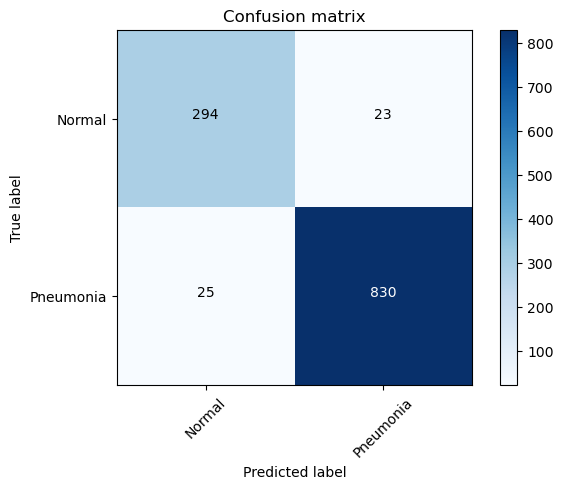

In [14]:
import itertools
pred_Y = model.predict(testX, batch_size = 8, verbose = True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['Normal','Pneumonia']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(testX, batch_size=BS)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
confusion_mtx = confusion_matrix(testY, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

## AUC ROC curve

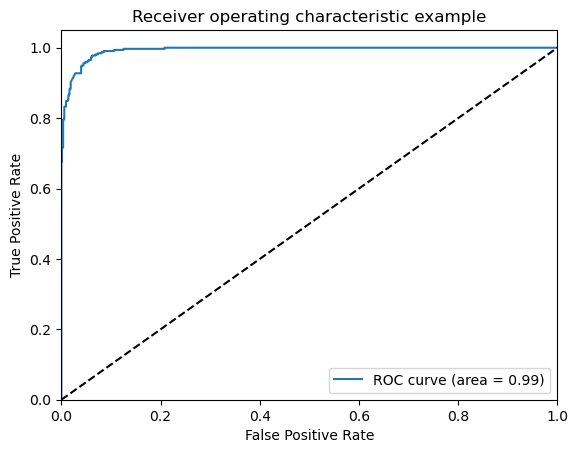

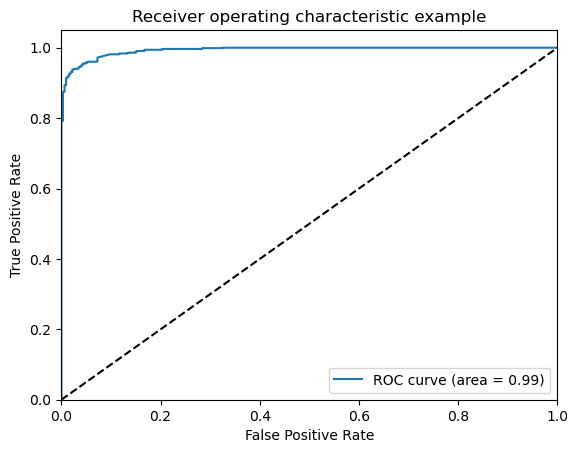

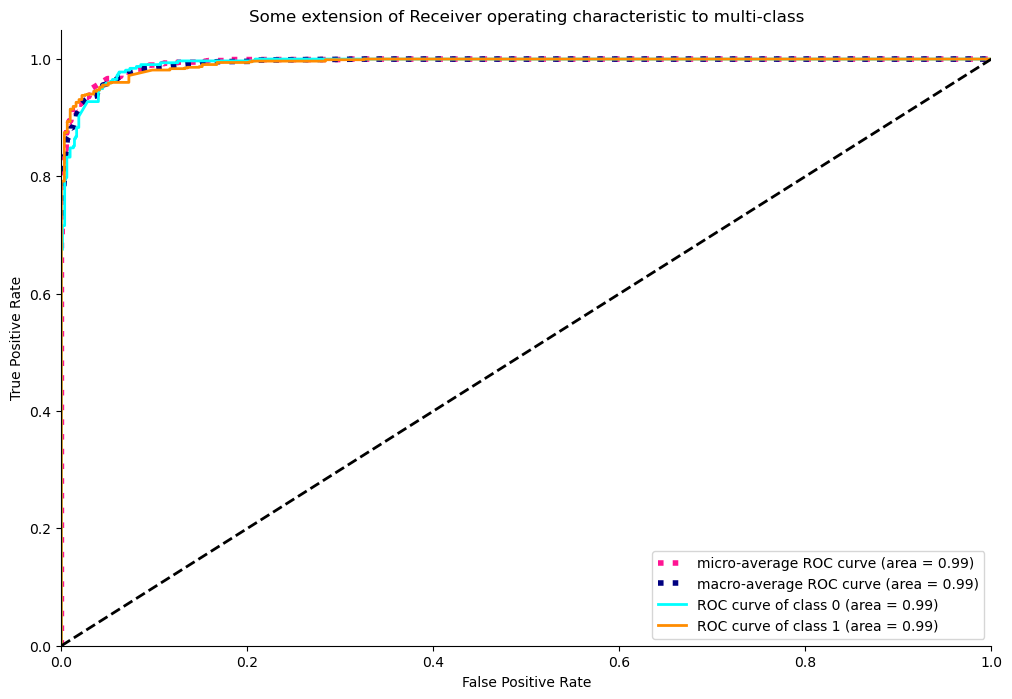

In [15]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_test = pd.get_dummies(testY)
y_test = np.array(y_test)

n_classes = 2


# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

# LIME

In [16]:
import tensorflow as tf
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

c:\Users\kusha\anaconda3\envs\venvP3_10\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


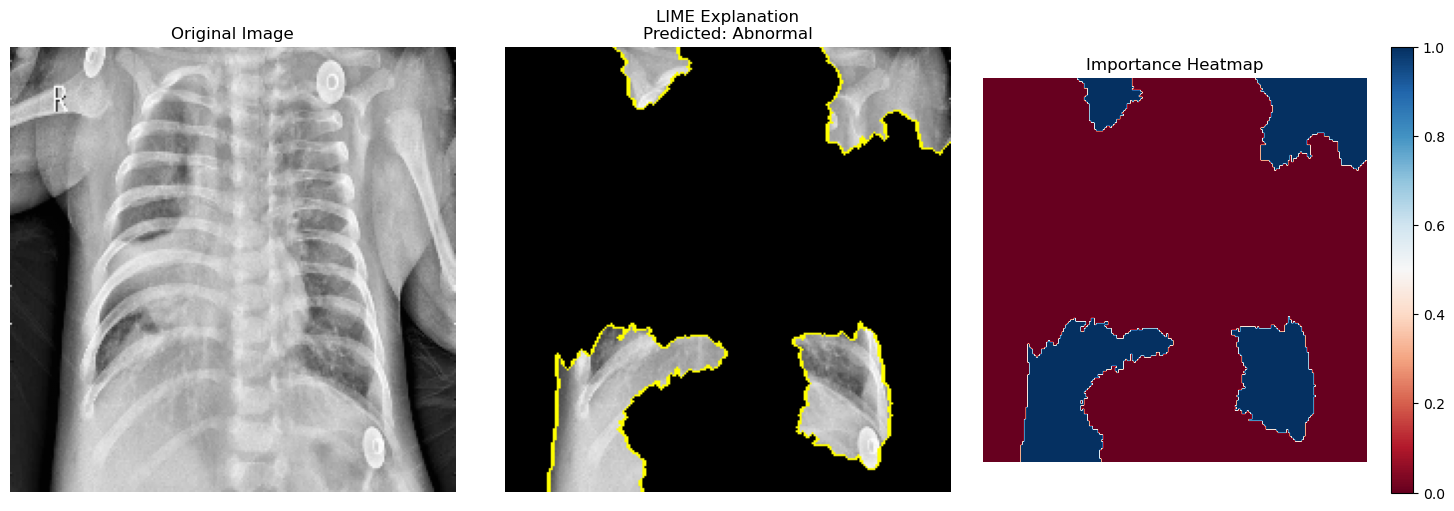


Top features that influenced the prediction:
Feature 7: Impact score = -0.0129
Feature 5: Impact score = 0.0107
Feature 0: Impact score = 0.0102
Feature 37: Impact score = 0.0101
Feature 16: Impact score = -0.0096


In [ ]:
def predict_wrapper(images):
    images = tf.cast(images, tf.float32)
    predictions = model.predict(images)
    return predictions

def explain_prediction(image, model, class_names=['Normal', 'Abnormal']):

    # Create the LIME explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Convert image to array if it's not
    image_array = np.array(image)
    
    # Generate explanation
    explanation = explainer.explain_instance(
        image_array, 
        predict_wrapper,
        top_labels=len(class_names),
        hide_color=0,
        num_samples=1000
    )
    
    # Get the most probable class
    top_label = explanation.top_labels[0]
    
    # Generate the explanation map
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=5,
        hide_rest=True
    )
    
    # Visualize the explanation
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(131)
    plt.imshow(image_array)
    plt.title('Original Image')
    plt.axis('off')
    
    # LIME explanation
    plt.subplot(132)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation\nPredicted: {class_names[top_label]}')
    plt.axis('off')
    
    # Heatmap only
    plt.subplot(133)
    plt.imshow(mask, cmap='RdBu')
    plt.title('Importance Heatmap')
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance scores
    print("\nTop features that influenced the prediction:")
    ind = explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    for feature, importance in sorted(dict_heatmap.items(), key=lambda x: abs(x[1]), reverse=True)[:5]:
        print(f"Feature {feature}: Impact score = {importance:.4f}")
explain_prediction(
    testX[10],
    model,
    class_names=['Normal', 'Abnormal']
)

In [22]:
# import lime
# from lime import lime_image

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(testX[10], model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


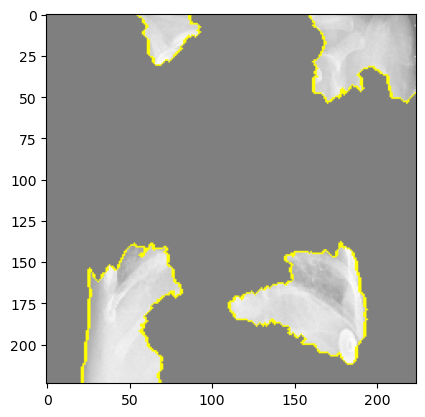

In [27]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

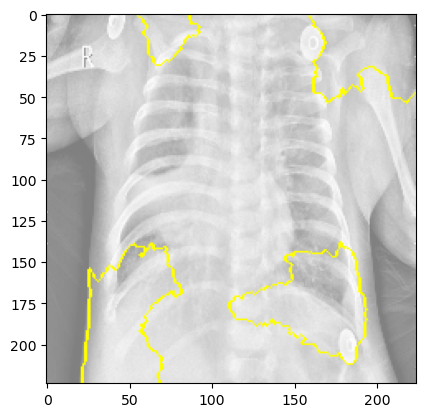

In [28]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

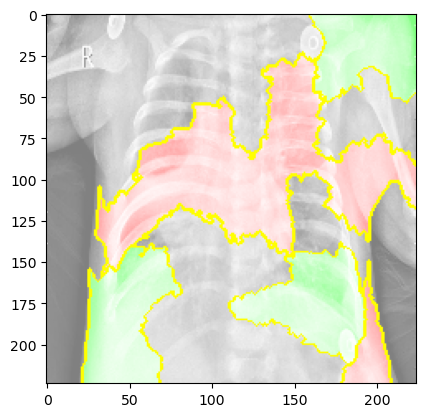

In [29]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

# Grad CAM

In [32]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.callbacks import Print

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Activation Maximization object
activation_maximization = ActivationMaximization(model, model_modifier)

# Define loss function. 20 is the imagenet index corresponding to ouzel.
loss = lambda x: K.mean(x[:, 1])

# Generate max activation with debug printing
activation = activation_maximization(loss, callbacks=[Print(interval=100)])
image = activation[0].numpy().astype(np.uint8)

f, ax = plt.subplots(figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
#ax.imshow(image)
#plt.show()

C:\Users\kusha\AppData\Local\Temp\ipykernel_19156\3194915606.py:17: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=100)])


Steps: 100	Scores: [51990.984375],	Regularization: [('TotalVariation2D', [24.20842742919922]), ('Norm', [29.99745750427246])]
Steps: 200	Scores: [36852.90234375],	Regularization: [('TotalVariation2D', [15.350780487060547]), ('Norm', [29.71816062927246])]


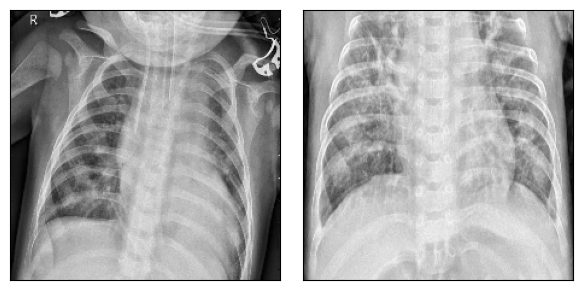

In [50]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


# Load images
img1 = testX[15]
img2 = testX[11]

images = np.asarray([np.array(img1), np.array(img2)])



# Render
subprot_args = {
    'nrows': 1,
    'ncols': 2,
    'figsize': (6, 3),
    'subplot_kw': {'xticks': [], 'yticks': []}
}
f, ax = plt.subplots(**subprot_args)
for i in range(len(images)):
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

In [39]:
# Define loss function. 1 is the imagenet index corresponding to Goldfish,
# And 294 is one corresponding to Bear.
def loss(output):
    return (output[1][1], output[0][1])

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

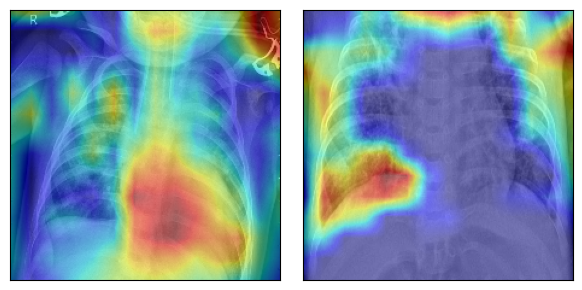

In [51]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

# Create Gradcam object
gradcam = Gradcam(model, model_modifier, clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss, images)
cam = normalize(cam)

f, ax = plt.subplots(**subprot_args)
for i in range(len(cam)):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


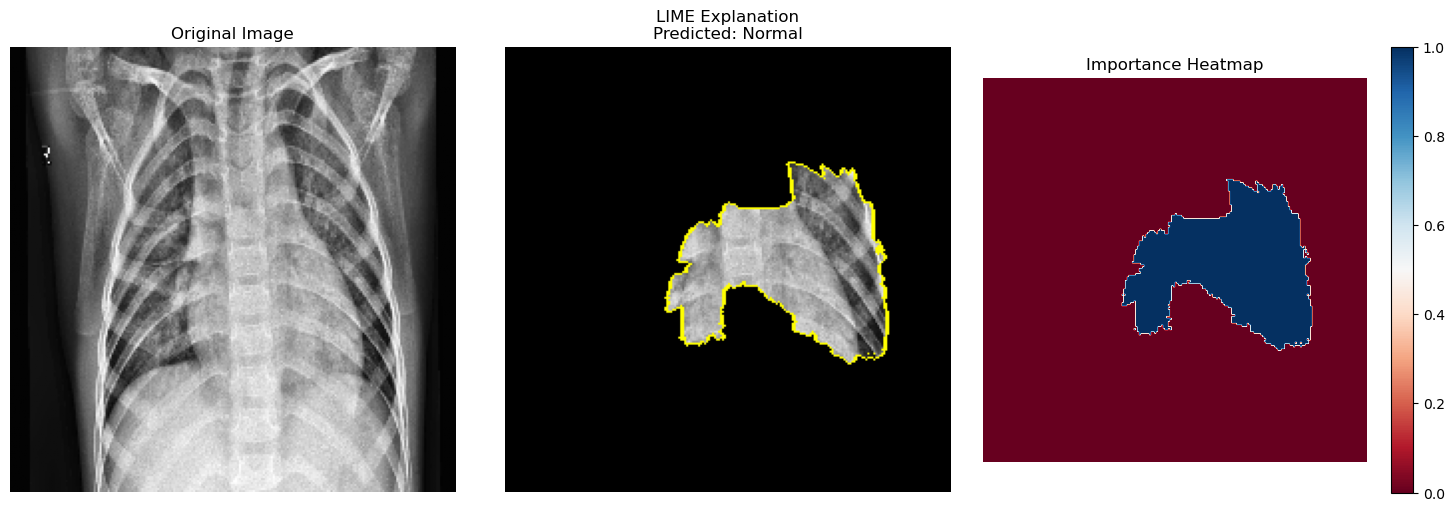


Top features that influenced the prediction:
Feature 17: Impact score = 0.1280
Feature 21: Impact score = 0.1097
Feature 25: Impact score = -0.0926
Feature 12: Impact score = 0.0891
Feature 0: Impact score = -0.0889


In [43]:
explain_prediction(
    testX[12],
    model,
    class_names=['Normal', 'Abnormal']
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


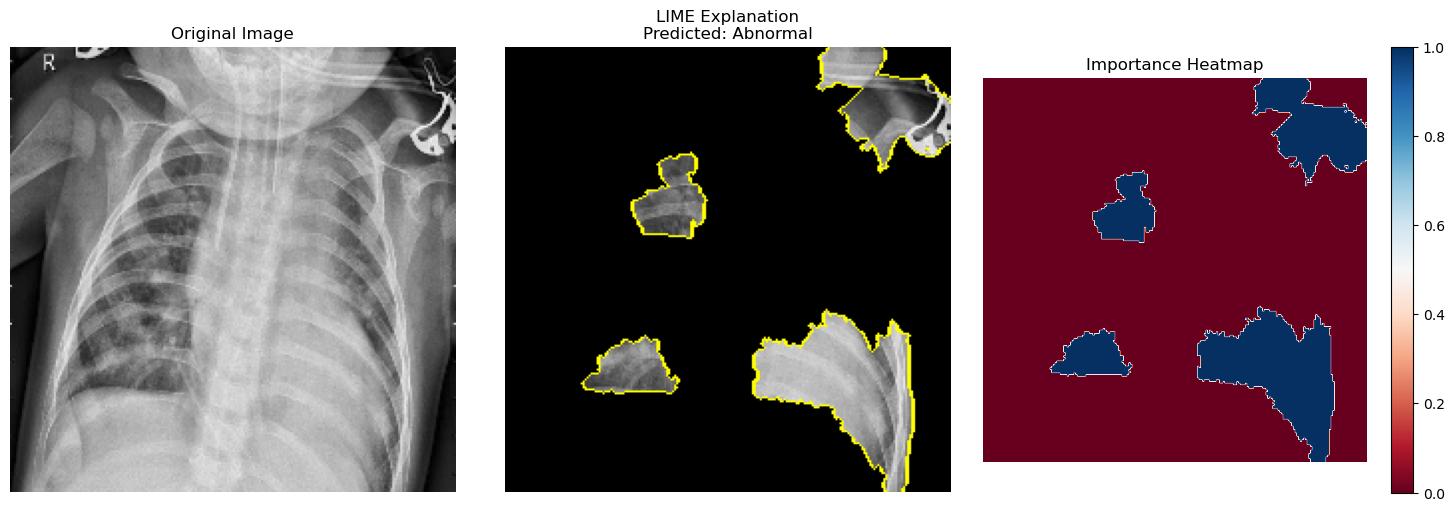


Top features that influenced the prediction:
Feature 21: Impact score = -0.2120
Feature 12: Impact score = 0.1486
Feature 13: Impact score = -0.1434
Feature 27: Impact score = 0.1143
Feature 17: Impact score = -0.0717


In [52]:
explain_prediction(
    testX[15],
    model,
    class_names=['Normal', 'Abnormal']
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


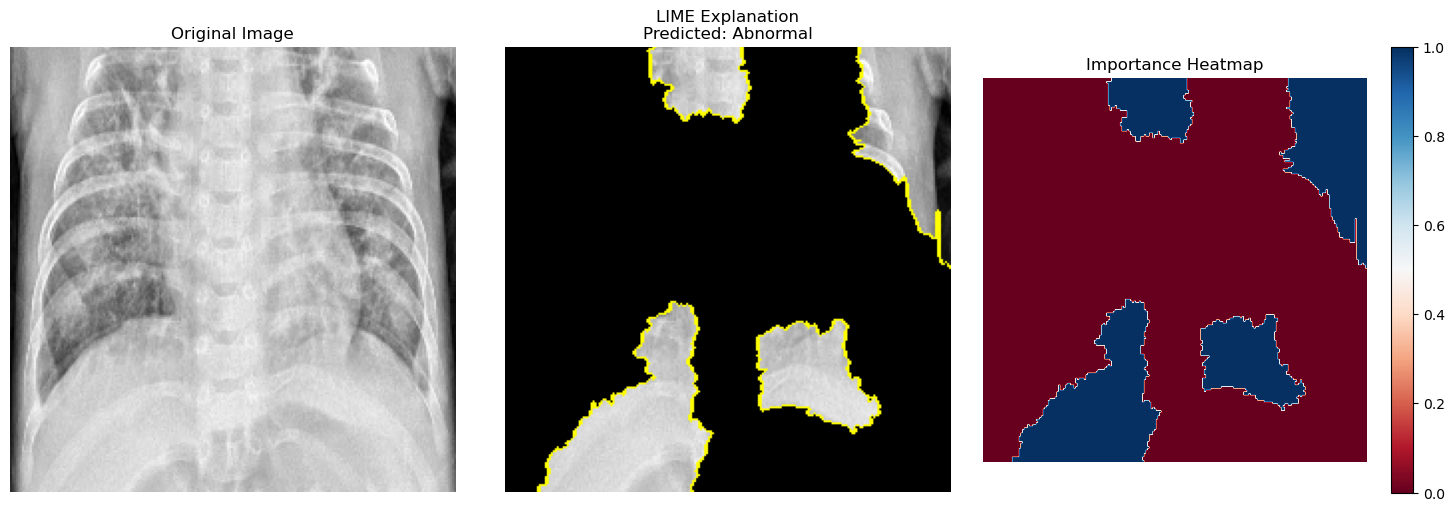


Top features that influenced the prediction:
Feature 3: Impact score = 0.0634
Feature 24: Impact score = 0.0542
Feature 14: Impact score = -0.0510
Feature 28: Impact score = 0.0499
Feature 16: Impact score = -0.0442


In [53]:
explain_prediction(
    testX[11],
    model,
    class_names=['Normal', 'Abnormal']
)